In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from glmtools.io.glm import GLMDataset, fix_event_locations
from glmtools.grid.clipping import QuadMeshSubset, QuadMeshPolySlicer

In [6]:
x = np.arange(5)
y = np.arange(6)+10

# x = np.arange(50)
# y = np.arange(60)+10
X,Y=np.meshgrid(x,y)
# Y += X*X

vals = (X[1:, 1:]+X[:-1, :-1])/( Y[1:, 1:]+Y[:-1, :-1])
print(X.shape, Y.shape, vals.shape)

lines = np.dstack((X, Y))
nh, nv, nd = lines.shape
print(lines[0:2, 0:2, :].tolist())

a_poly = [(.5,12), (.7,13), (1.2,15), (.9, 11)]

N_polys = 1
polys = np.asarray([a_poly] * N_polys)
# polys += np.random.rand(N_polys,4,2)

(6, 5) (6, 5) (5, 4)
[[[0, 10], [1, 10]], [[0, 11], [1, 11]]]


In [7]:
mesh = QuadMeshSubset(X, Y, n_neighbors=16)

slicer = QuadMeshPolySlicer(mesh)

chopped_polys = slicer.slice(polys)
# print(chopped_polys)

def gen_polys(chopped_polys):
    for subquads, areas  in chopped_polys:
        for subquad, area in zip(subquads, areas):
            print(area)
            yield (subquad, area)
#             for subquad_poly, subquad_area in quad_data:
#                 print(subquad_poly)
#                 yield subquad_poly
#         for polys_this_quad, poly_areas in this_poly:
#             for p, area in zip(target_polys, poly_areas):
#                 if len(p) > 2:
#                     yield p, area

        
good_polys = [p for p in gen_polys(chopped_polys)]

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.
0.0166666665541
0.237499999814
0.395833333386
0.087499999674


In [8]:
# polys_per_quad = polys_to_mesh(poly, X, Y)
# for p in polys_per_quad:
#     print(p)
    
# def gen_polys(polys_per_quad):
#     for polys_this_quad, poly_areas in polys_per_quad:
#         for target_polys in polys_this_quad:
#             for p, area in zip(target_polys, poly_areas):
#                 if len(p) > 2:
#                     yield p, area

        
# good_polys = [p for p in gen_polys(polys_per_quad)]

[ 0.16209368  0.16209368  0.16209368  0.16209368]


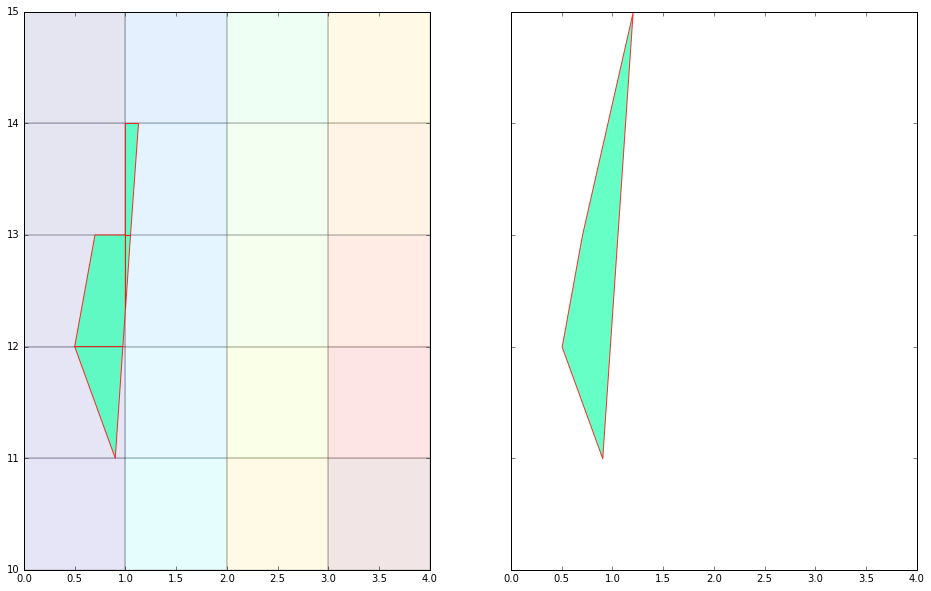

In [9]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

pm = ax.pcolormesh(X, Y, vals, edgecolor='black', alpha=0.1)
patches = [Polygon(p, True) for p, area in good_polys]
patch_coll = PatchCollection(patches, edgecolor='red', norm=pm.norm, alpha=0.8)
patch_vals = vals.mean()*np.ones((len(patches),))
print(patch_vals)
patch_coll.set_array(patch_vals)
ax.add_collection(patch_coll)
# plt.colorbar(patch_coll)

patches = [Polygon(p, True) for p in polys]
patch_coll = PatchCollection(patches, edgecolor='red', norm=pm.norm, alpha=0.8)
patch_vals = vals.mean()*np.ones((len(patches),))
patch_coll.set_array(patch_vals)
ax1.add_collection(patch_coll)

# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))

In [15]:
for p in poly:
    print(np.asarray(p).mean(axis=0))

[  0.825  12.75 ]


In [ ]:
# filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20171161230400_e20171161231000_c20171161231027.nc'

# # glm = GLMDataset(filename)
# glm = netCDF4.Dataset(filename)
